# wongds_prescriber_rx
A Python-based approach for a Tufts Biomedical Data Science Club project to determine whether patterns exist between prescriber demographic information and opioid prescription.

## Datasets
### Prescriber attributes
https://www.kaggle.com/roamresearch/prescriptionbasedprediction
A single JSONL file, each line of which is a single healthcare provider. Each line contains data in the following format:
```json
{
    'provider_variables': 
        {
            'brand_name_rx_count': int,
            'gender': 'M' or 'F',
            'generic_rx_count': int,
            'region': 'South' or 'MidWest' or 'Northeast' or 'West',
            'settlement_type': 'non-urban' or 'urban'
            'specialty': str
            'years_practicing': int
        },
     'npi': str,
     'cms_prescription_counts':
        {
            `drug_name`: int, 
            `drug_name`: int, 
            ...
        }
}
```
More information is available in this blog post: http://roamanalytics.com/2016/09/13/prescription-based-prediction/

### Opiate prescriptions
https://www.kaggle.com/apryor6/us-opiate-prescriptions
Consists of three files, `opioids.csv`, `overdoses.csv`, and `prescriber-info.csv`.
- `opioids.csv` is a two-column list of opioids first their names, and second, their generic names. Generic names also appear in the list of drug names.
- `overdoses.csv` is a four-column list of states, the populations of those states, the number of opioid-related deaths in those states in 2014, and the postal abbreviation for those states.
- `prescriber-info.csv` is a very wide table of data consisting of many columns: NPI, gender, state, credentials, and specialty of prescribers, followed by counts of individual opioids prescribed by that provider.

## Packages/Libraries
### numpy, scikit-learn, pandas, ggplot
Already included as part of `condas` installation; install via `pip` if not already present:
```shell
sudo python3 -m pip install numpy scikit-learn pandas ggplot
```

### jsonlines
A python library to work with JSONL files. Install via `pip`:
```bash
sudo python3 -m pip install jsonlines
```

### baseplot
Tool for plotting maps in Python.
#### Linux
1. Install required packages: 
```
pip install binutils libproj-dev gdal-bin libgeos-dev
```
2. Download the latest version of `basemap`. Version 1.1.0 should resolve a lot of issues once it is released, but only 1.0.7 is currently available: https://github.com/matplotlib/basemap/releases
3. Decompress basemap and edit setup.py between line 86 to remove `'geos'` from the list of libraries:
```python
else:
    extensions.append(Extension("_geoslib",['src/_geoslib.c'],
                                library_dirs=geos_library_dirs,
                                runtime_library_dirs=geos_library_dirs,
                                include_dirs=geos_include_dirs,
                                libraries=['geos_c', 'geos']))
```
to
```python
else:
    extensions.append(Extension("_geoslib",['src/_geoslib.c'],
                                library_dirs=geos_library_dirs,
                                runtime_library_dirs=geos_library_dirs,
                                include_dirs=geos_include_dirs,
                                libraries=['geos_c']))
```
4. Install modified basemap 1.0.7: `sudo python3 setup.py install` or use pip: `sudo pip install .`

#### Windows
1. Install GEOS package: http://trac.osgeo.org/osgeo4w/ or http://www.lfd.uci.edu/~gohlke/pythonlibs/#shapely for Windows, .
2. Install Microsoft Visual Studio Community, modify install to include C++ Build Tools (or just install standalone MS VS C++ Build Tools): https://www.visualstudio.com/downloads/ or http://landinghub.visualstudio.com/visual-cpp-build-tools
3. Download the latest version of `basemap`. Version 1.1.0 should resolve a lot of issues once it is released, but only 1.0.7 is currently available: https://github.com/matplotlib/basemap/releases
4. Decompress basemap and edit setup.py between line 79 to change `libraries=['geos']` to `libraries=['geos_c']`:
```python
if sys.platform == 'win32':
# don't use runtime_library_dirs on windows (workaround
# for a distutils bug - http://bugs.python.org/issue2437).
    #extensions.append(Extension("mpl_toolkits.basemap._geoslib",['src/_geoslib.c'],
    extensions.append(Extension("_geoslib",['src/_geoslib.c'],
                                library_dirs=geos_library_dirs,
                                include_dirs=geos_include_dirs,
                                libraries=['geos']))
```
to
```python
if sys.platform == 'win32':
# don't use runtime_library_dirs on windows (workaround
# for a distutils bug - http://bugs.python.org/issue2437).
    #extensions.append(Extension("mpl_toolkits.basemap._geoslib",['src/_geoslib.c'],
    extensions.append(Extension("_geoslib",['src/_geoslib.c'],
                                library_dirs=geos_library_dirs,
                                include_dirs=geos_include_dirs,
                                libraries=['geos_c']))
```
Set the location for the GEOS library. This is the directory that contains both `geos_c.dll` and `geos_c.h`, typically as `$GEOS_DIR\bin\geos_c.dll` and `$GEOS_DIR\include\geos_c.h`:
```shell
set GEOS_DIR=C:\OSGeo4W64
```
Then install `basemap` using MSBuild Command Prompt:
```shell
python setup.py build --compiler=msvc install
```
Edit system environment variable for Path to include `C:\OSGeo4W64\bin`. `Control Panel`>`System and Security`>`System`>`Advanced system settings`>`Advanced`>`Environment Variables`>`Path`>`Edit`

Before `basemap` will be available in `conda`, you will need to install it in the `conda` environment. Open an Andaconda Prompt and navigate to the `basemap` source we've been working with. Install it using `pip` inside the Anaconda environment where `setup.py` is located:
```shell
pip install .
```

_This site was really helpful: http://blog.straywarrior.com/179.html_

In [3]:
# Load some useful libraries
import csv
import jsonlines
import copy
from pprint import pprint
import pandas as pd
import numpy as np
from ggplot import *
import matplotlib
import matplotlib.pyplot as plt

## Geographic considerations
The provider and opiate datasets likely have some geographic distribution that will influence our analysis, so we should do some exploratory analysis of the data to try and figure out what that looks like.

In [1]:
# Load the Matplot library and Basemap toolkit
# Use this to visualize the geographic distribution of providers,
# opioid-related deaths, and population.
# See if our data is biased.
from mpl_toolkits.basemap import Basemap

In [10]:
# Start building our map
# Put together a map of the contiguous 48 US states
map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
map.readshapefile('map_files/st99_d00', name='states', drawbounds=True)
# Render the map object. Opens a new dialog window.
#plt.show()

## Loading datasets
The opioid dataset has a list of opioids, so that will be useful to use to filter through the provider dataset, which has extra information we might not need right away.

In [4]:
# Start examining data
# Load data
# Opiate dataset
opiate_class_data = 'dataset_rx/opioids.csv'
opiate_prescriber_data = 'dataset_rx/prescriber-info.csv'
opiate_overdose_data = 'dataset_rx/overdoses.csv'

# List of opiates
opioids = pd.read_csv(opiate_class_data)

# Opiate prescriber info
opiate_prescribers = pd.read_csv(opiate_prescriber_data)

# Opiate overdoses, by US State
opiate_overdoses = pd.read_csv(opiate_overdose_data)

In [5]:
# Prescriber attribute dataset
prescriber_attr_dataset = 'dataset_prescriber/roam_prescription_based_prediction.jsonl'

# Build a list of dictionaries containing prescriber data, and dict of provider variables
prescriber_attr_data = []
prescriber_var_data = {'npi': []}
with jsonlines.open(prescriber_attr_dataset) as reader:
    for obj in reader:
        prescriber_attr_data.append(obj)
        prescriber_var_data['npi'].append(obj['npi'])
        for key, value in obj['provider_variables'].items():
            try:
                prescriber_var_data[key].append(value)
            except KeyError:
                prescriber_var_data[key] = [value]

# Make a dataframe just for the provider variables
prescriber_info_df = pd.DataFrame(prescriber_var_data)

## Filter provider data
Look for providers who prescribed opiates. Build this list, then grab their demographic information from the dataframe created from the `provider_variables` section of the JSONL data.

In [53]:
# Look for prescription of opiates in prescriber_data
opioid_prescribers = {'Drug Name': [],
                      'npi': [],
                     }

# Cycle through each prescriber record
for prescriber in prescriber_attr_data:
    # Look for opioids by Drug Name, and make a record of prescriber by npi.
    # Generic names also appear in 'Drug Name' list.
    for drug in opioids['Drug Name']:
        if drug in prescriber['cms_prescription_counts'].keys():
            opioid_prescribers['Drug Name'].append(drug)
            opioid_prescribers['npi'].append(prescriber['npi'])

# Convert the dictionary to a dataframe and save to csv.
# Use this dataframe to unify prescriber attributes and opioid prescription.
opioid_prescriber_df = pd.DataFrame(opioid_prescribers)
opioid_prescriber_df.to_csv('output/opioid_prescribers.csv')

# Add back demographic data for these providers
pndf = opioid_prescriber_df.merge(pd.DataFrame(prescriber_var_data), left_on='npi', right_on='npi')

In [54]:
# Make a list of opioid prescribes and their info, without the drug data
unique_prescriber_npi_df = pd.DataFrame({'npi': list(set(opioid_prescriber_df["npi"]))})
upndf = unique_prescriber_npi_df.merge(pd.DataFrame(prescriber_var_data), left_on='npi', right_on='npi')

<IPython.core.display.Javascript object>


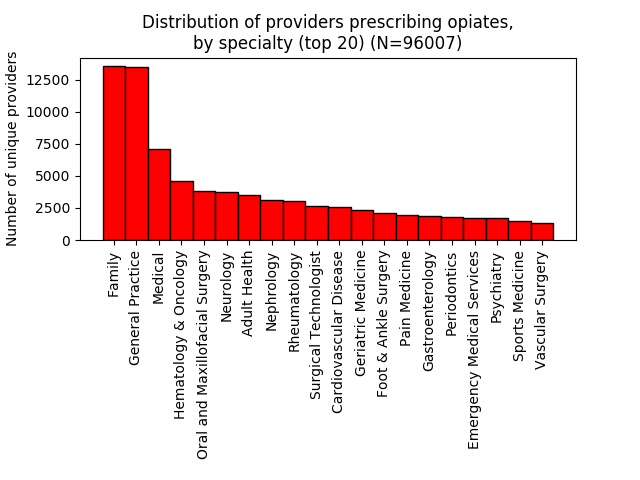

In [60]:
# Set up plot of specialties in opiate prescribers
#specialties = pd.DataFrame({'specialty': sorted(set(pndf.specialty))})
specialty_freq = pd.DataFrame(upndf.groupby('specialty').size().rename('freq'))
specialty_freq['specialty'] = specialty_freq.index
specialty_freq_sorted = specialty_freq.sort_values(by='freq', ascending=0)
specialty_total = sum(specialty_freq['freq'])

#print(specialties)
#print(specialty_freq)

# Check for accuracy
#print(len(pndf.specialty[pndf.specialty == 'Acute Care']))
#print(len(pndf.specialty[pndf.specialty == 'Clinical']))
#print(specialty_freq.reindex_axis(sorted(specialty_freq.columns)))

# Make a plot
%matplotlib notebook
# How many items
N = len(specialty_freq_sorted[0:20])
ind = np.arange(N)
width = 1
fig, ax = plt.subplots()
# Set dimensions and color of each bar
rects = ax.bar(ind, specialty_freq_sorted['freq'][0:20], width, color='red', edgecolor='black')
# Label the plot
ax.set_ylabel('Number of unique providers')
ax.set_xticks(ind)
ax.set_xticklabels(specialty_freq_sorted['specialty'][0:20], rotation=90)
ax.set_title('Distribution of providers prescribing opiates,\nby specialty (top 20) (N=' + str(specialty_total) +')')
fig.subplots_adjust(bottom=0.5)

plt.show()
fig.savefig('output/top_20_prescrib_specialties.png', bbox_inches='tight')

## Top prescribing specialties
This is interesting, but perhaps not very informative. Some specialties may be over-represented in this data. Additionally, this is based on unique providers, not the number of prescriptions written by each provider. Let's do the same analysis again, but with the prescription data still present.

<IPython.core.display.Javascript object>


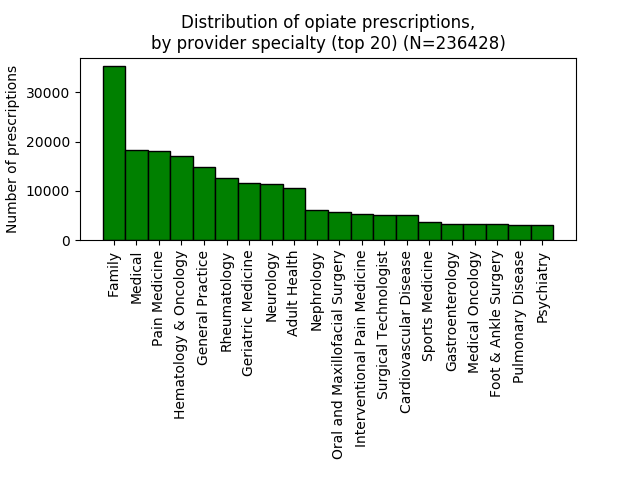

In [61]:
prescription_freq = pd.DataFrame(pndf.groupby('specialty').size().rename('freq'))
prescription_freq['specialty'] = prescription_freq.index
prescription_freq_sorted = prescription_freq.sort_values(by='freq', ascending=0)
prescription_total = sum(prescription_freq['freq'])

# Make a plot
%matplotlib notebook
# How many items
N = len(prescription_freq_sorted[0:20])
ind = np.arange(N)
width = 1
fig, ax = plt.subplots()
# Set dimensions and color of each bar
rects = ax.bar(ind, prescription_freq_sorted['freq'][0:20], width, color='green', edgecolor='black')
# Label the plot
ax.set_ylabel('Number of prescriptions')
ax.set_xticks(ind)
ax.set_xticklabels(prescription_freq_sorted['specialty'][0:20], rotation=90)
ax.set_title('Distribution of opiate prescriptions,\nby provider specialty (top 20) (N=' + str(prescription_total) +')')
fig.subplots_adjust(bottom=0.5)

plt.show()
fig.savefig('output/top_20_prescriptions_specialty.png', bbox_inches='tight')

## Highest number of prescriptions, by specialty
This makes a little more sense; specialties we'd expect, like Pain Medicine, move higher. Interesting that Family Medicine stays at the top, while General Practice falls a bit. It is *really* interesting that Family Medicine is so much higher than the next nearest specialty.